# Long Short Term Memory (LSTM) Classification of uci_HAR time sequences

### Dataset

uci_HAR dataset also includes the **time sequences** of Accelerometer & Gyroscope signals of each record before extracting the features.
They are available for the train and test data. Their descriptions are equivalent. 

- 'train/Inertial Signals/**total_acc_x_train.txt**': The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. The same description applies for the 'total_acc_y_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 

- 'train/Inertial Signals/**body_acc_x_train.txt**': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 

- 'train/Inertial Signals/**body_gyro_x_train.txt**': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 

- 'train/subject_train.txt': Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 

### Algorithm
In this notebook, we use time sequences in train folder to train a simple LSTM RNN network, then use this LSTM to classify each time sequence in test folder, and compare the results to the true test label to evaluate the accuracy.

For each observation in time sequences, there are 9 features:
- body_acc_x_train
- body_acc_y_train
- body_acc_z_train
- total_acc_x_train
- total_acc_y_train
- total_acc_z_train
- body_gyro_x_train
- body_gyro_y_train
- body_gyro_z_train

Thus the input feature size of LSTM is 9, and the hidden dimension of LSTM is also 9.

This LSTM model has sequence input, but one output (classification), it corresponds to following graph:
> 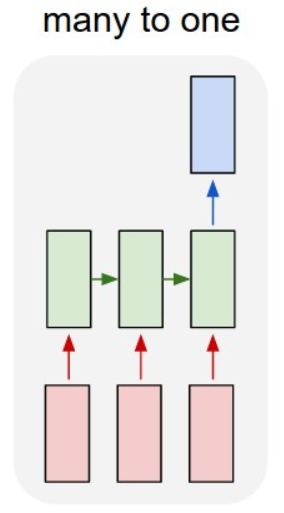
> Reference: PyTorch Tutorials -- "Sequence Models and Long-Short Term Memory Networks"

This notebook was run on Google Colab.

### Import the necessary packets 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install torch

In [0]:
import numpy as np
import pandas as pd
from time import time
import matplotlib as mpl
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Data loading and formatting

In [0]:
google_drive = 'drive/My Drive/UCI_HAR/'

y_train = pd.read_csv(google_drive+'train/y_train.txt', sep='\n', header=None, names=['Activity No.'])
y_test = pd.read_csv(google_drive+'test/y_test.txt', sep='\n', header=None, names=['Activity No.'])

body_acc_x_train = pd.read_csv(google_drive+'train/Inertial Signals/body_acc_x_train.txt', sep='\s+', header=None, index_col=False)
body_acc_y_train = pd.read_csv(google_drive+'train/Inertial Signals/body_acc_y_train.txt', sep='\s+', header=None, index_col=False)
body_acc_z_train = pd.read_csv(google_drive+'train/Inertial Signals/body_acc_z_train.txt', sep='\s+', header=None, index_col=False)
body_gyro_x_train = pd.read_csv(google_drive+'train/Inertial Signals/body_gyro_x_train.txt', sep='\s+', header=None, index_col=False)
body_gyro_y_train = pd.read_csv(google_drive+'train/Inertial Signals/body_gyro_y_train.txt', sep='\s+', header=None, index_col=False)
body_gyro_z_train = pd.read_csv(google_drive+'train/Inertial Signals/body_gyro_z_train.txt', sep='\s+', header=None, index_col=False)
total_acc_x_train = pd.read_csv(google_drive+'train/Inertial Signals/total_acc_x_train.txt', sep='\s+', header=None, index_col=False)
total_acc_y_train = pd.read_csv(google_drive+'train/Inertial Signals/total_acc_y_train.txt', sep='\s+', header=None, index_col=False)
total_acc_z_train = pd.read_csv(google_drive+'train/Inertial Signals/total_acc_z_train.txt', sep='\s+', header=None, index_col=False)

body_acc_x_test = pd.read_csv(google_drive+'test/Inertial Signals/body_acc_x_test.txt', sep='\s+', header=None, index_col=False)
body_acc_y_test = pd.read_csv(google_drive+'test/Inertial Signals/body_acc_y_test.txt', sep='\s+', header=None, index_col=False)
body_acc_z_test = pd.read_csv(google_drive+'test/Inertial Signals/body_acc_z_test.txt', sep='\s+', header=None, index_col=False)
body_gyro_x_test = pd.read_csv(google_drive+'test/Inertial Signals/body_gyro_x_test.txt', sep='\s+', header=None, index_col=False)
body_gyro_y_test = pd.read_csv(google_drive+'test/Inertial Signals/body_gyro_y_test.txt', sep='\s+', header=None, index_col=False)
body_gyro_z_test = pd.read_csv(google_drive+'test/Inertial Signals/body_gyro_z_test.txt', sep='\s+', header=None, index_col=False)
total_acc_x_test = pd.read_csv(google_drive+'test/Inertial Signals/total_acc_x_test.txt', sep='\s+', header=None, index_col=False)
total_acc_y_test = pd.read_csv(google_drive+'test/Inertial Signals/total_acc_y_test.txt', sep='\s+', header=None, index_col=False)
total_acc_z_test = pd.read_csv(google_drive+'test/Inertial Signals/total_acc_z_test.txt', sep='\s+', header=None, index_col=False)

In [0]:
# Time sequences of training, each observation has 9 features stacked
sequence_train = np.dstack((body_acc_x_train, body_acc_y_train, body_acc_z_train, body_gyro_x_train, body_gyro_y_train, body_gyro_z_train, total_acc_x_train, total_acc_y_train, total_acc_z_train))
# Time sequences of testing, each observation has 9 features stacked
sequence_test = np.dstack((body_acc_x_test, body_acc_y_test, body_acc_z_test, body_gyro_x_test, body_gyro_y_test, body_gyro_z_test, total_acc_x_test, total_acc_y_test, total_acc_z_test))

# Convert to tensor
sequence_train_tensor = torch.Tensor(sequence_train)
sequence_test_tensor = torch.Tensor(sequence_test)
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)

y_test_true = y_test.values.flatten()

### Create LSTM model

In [0]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_feature_size, hidden_dimension, label_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dimension = hidden_dimension
        self.lstm = nn.LSTM(input_size=input_feature_size, hidden_size=hidden_dimension)
        # The linear layer that maps from hidden state space to label space
        self.hidden2label = nn.Linear(in_features=hidden_dimension, out_features=label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dimension), # h_0
                torch.zeros(1, 1, self.hidden_dimension)) # c_0

    def forward(self, sequence):
        lstm_out, self.hidden = self.lstm(sequence.view(128, 1, 9), self.hidden)
        label_space = self.hidden2label(lstm_out[-1])
        label_scores = F.log_softmax(label_space, dim=1)
        return label_scores

### Initialize LSTM mode

In [0]:
INPUT_FEATURE_SIZE = 9
HIDDEN_DIMENSION = 9
LABEL_SIZE = 6

# Initialize the LSTM model
model = LSTMClassifier(INPUT_FEATURE_SIZE, HIDDEN_DIMENSION, LABEL_SIZE)
# use NLLLoss to directly calculate the loss between LSTM output and training label
loss_function = nn.NLLLoss()
# use Adam as optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Before training, check the accuracy of this LSTM model on test data
with torch.no_grad():
    scores = np.empty((0,6))
    for sequence in sequence_test_tensor:
        score = model(sequence)
        scores = np.vstack((scores, score.reshape(1,6)))

    y_test_predict = np.argmax(scores, axis=1) + 1
    accuracy = np.sum(y_test_predict == y_test_true) / len(y_test_true)
    print('Accuracy = %.3f' % (accuracy))

Accuracy = 0.171


Before training, the accuracy of this LSTM classification model on time sequences of testing is only 17.1%, close to the random guess probability = 1/6 (6 activities)

### Train LSTM model

Train LSTM model using time sequences of training, and their corresponding labels:

In [36]:
for epoch in range(50):
    start_time = time()
    
    for i in range(len(sequence_train_tensor)):
        # Clear out Pytorch accumulates gradients
        model.zero_grad()

        # Clear out the hidden state of the LSTM
        model.hidden = model.init_hidden()

        # Get inputs of LSTM: each time sequence of training, and the corresponding label
        sequence = sequence_train_tensor[i]
        label = y_train_tensor[i]

        # Run forward pass.
        label_scores = model(sequence)

        # Compute the loss, gradients, and update the parameters by calling optimizer.step()
        loss = loss_function(label_scores, label)
        loss.backward()
        optimizer.step()
    
    end_time = time()
    run_time_minute = (end_time-start_time)/60
    print('Epoch %d\t\tRun time = %.2f minutes\t\tLoss = %.3f' % (epoch, run_time_minute, loss))

Epoch 0		Run time = 2.23 minutes		Loss = 0.666
Epoch 1		Run time = 2.21 minutes		Loss = 0.454
Epoch 2		Run time = 2.23 minutes		Loss = 0.561
Epoch 3		Run time = 2.24 minutes		Loss = 0.142
Epoch 4		Run time = 2.23 minutes		Loss = 0.136
Epoch 5		Run time = 2.25 minutes		Loss = 0.081
Epoch 6		Run time = 2.26 minutes		Loss = 0.059
Epoch 7		Run time = 2.25 minutes		Loss = 0.094
Epoch 8		Run time = 2.24 minutes		Loss = 0.011
Epoch 9		Run time = 2.24 minutes		Loss = 0.009
Epoch 10		Run time = 2.24 minutes		Loss = 0.012
Epoch 11		Run time = 2.24 minutes		Loss = 0.006
Epoch 12		Run time = 2.25 minutes		Loss = 0.004
Epoch 13		Run time = 2.24 minutes		Loss = 0.001
Epoch 14		Run time = 2.24 minutes		Loss = 0.001
Epoch 15		Run time = 2.25 minutes		Loss = 0.007
Epoch 16		Run time = 2.26 minutes		Loss = 0.001
Epoch 17		Run time = 2.26 minutes		Loss = 0.003
Epoch 18		Run time = 2.24 minutes		Loss = 0.000
Epoch 19		Run time = 2.25 minutes		Loss = 0.001
Epoch 20		Run time = 2.26 minutes		Loss = 0.002
Ep

The script has printed the run time and the loss after each epoch.

### Test LSTM model

In [0]:
# After training, check the accuracy of this LSTM model on test data
with torch.no_grad():
    scores = np.empty((0,6))
    for sequence in sequence_test_tensor:
        score = model(sequence)
        scores = np.vstack((scores, score.reshape(1,6)))

    y_test_predict = np.argmax(scores, axis=1) + 1
    accuracy = np.sum(y_test_predict == y_test_true) / len(y_test_true)
    print('Accuracy = %.3f' % (accuracy))

Accuracy = 0.854


### Conclusion
After training, the accuracy of the LSTM classification model is **85.4%**, which is much higher than the accuracy before training (17.1%).
This means that the LSTM model is well trained for uci_HAR time sequence classification.

However, from above printing output, we can see that after Epoch 11, the loss doesn't have significant reduce. So the Epoch after 11 should generate over-fitting. If the LSTM model training stops at Epoch 10, the final accuracy on test data should be better. For time reason, I will try it later.